In [1]:
%load_ext autoreload
%config Completer.use_jedi = False

In [2]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt


# Topology optimization for the fundamental frequency of a vibrating structure

## 1. Example problem definition

In [79]:
mesh = FEMOL.mesh.rectangle_Q4(20, 20, 15, 15)

problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plane')
material1 = FEMOL.materials.isotropic_bending_benchmark()
problem.define_materials(material1)
problem.define_tensors(1)  # thick=1

problem.add_fixed_domain(FEMOL.domains.inside_box([0], [[0, 15]]), ddls=[0, 1])

#problem.add_forces(force=[0, 0, -1, 0, 0, 0], domain=FEMOL.domains.inside_box([[9,11]], [[9,11]]))

w, v = problem.solve(filtre=0)


solving using scipy
solved in :  0.18677115440368652  s


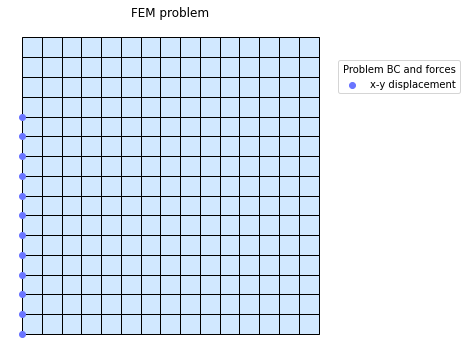

In [84]:
problem.plot()

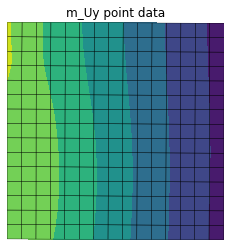

In [85]:
mesh.add_mode('m', v[24], 2)
mesh.plot.point_data('m_Uy')
reference_vector = v[0]  # Save for MAC Analysis

## 2. The optimization problem formulation

### Optimization problem constraints

maximize : $\; min\; (\omega_j^2) \;\; j = 1,...,J $

with : $\; \rho_1, ..., \rho_{N_E}$ The individual element densities of the problem

and : $j = 1,...,J$ The vibration modes of the structure

Subject to :

The eigenvalue theorem : 

$ K \phi_j = \omega_j^2 M \phi_j \; \; j = 1, ..., J$

The orthogonality criteria :

$ \phi_j^T M \phi_k = \delta_{jk}, \; \; j \geq k, \;\; kj = 1,...,J$

Where : $\delta_{jk} = 1$ if $i=k$ and $0$ if $j \neq k$

The Volume constraint :

$\sum_{e=1}^{N_e} \; \rho_e V_e - V^* \leq 0$ and $V^* = \alpha V_0$

Where : $\alpha$ is the volume fraction constraint and $V_0$ is the domain volume

And the admissible density values :

$0 < \rho_{min} \leq \rho_e \leq 1$ for $e = 1, ..., N_e$

Here, $\rho_{min}$ represents the admissible lower bound to the element density (typically $10^{-3}$)

### Sensitivity Analysis

The sensibility of the eigenvalue is given by $\frac{\partial \lambda_j}{\partial \rho_e}$ where $\lambda_j = \omega_j^2$ is obtained by differentiating the eigenvalue theorem with respect to $\rho_e$ :



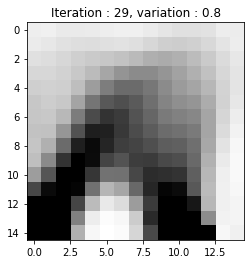

In [86]:
SIMP = FEMOL.SIMP_VIBE(problem, objective='max eig')
mesh = SIMP.solve(v[24])

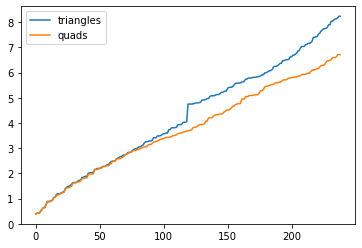

In [350]:

    
plt.plot(w[0], label='triangles')
plt.plot(w[1], label='quads')
plt.legend()
plt.show()

In [364]:
np.isclose(w[0][:15] - w[1][:15], 0, atol=1e-1).all()

True

array([0.39139824, 0.41777477, 0.41777477, 0.44184539, 0.50498038, 0.5795857 , 0.63699443, 0.63699443, 0.75195077, 0.86569394])

In [343]:
REF_W = np.array([3363.6, 3836.4, 5217.5, 5380.5,
                  6624, 6749.3, 6929, 7019.3, 8093,
                  8476.5, 8530.6, 9258, 9328.1, 9887.7])

# Circle mesh with R = 0.5 and ~25 ** 2 elements
R = 0.5  # m
N_ele = 25
mesh = FEMOL.mesh.circle_Q4(R, N_ele)

# Problem definition
thickness = 0.005
aluminium = FEMOL.materials.IsotropicMaterial(71e9, 0.33, 2700)

# Create a FEM Problem from the mesh (compute displacement with a plate bending model)
problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plane')
problem.define_materials(aluminium)
problem.define_tensors(thickness)

circle_domain = FEMOL.domains.outside_circle(0, 0, R - 0.005)

# Fix all the degrees of freedom
problem.add_fixed_domain(circle_domain)
problem.assemble('K')
problem.assemble('M')

# Solve the eigenvalue problem and store the frequencies
w, _ = problem.solve(filtre=2)

# Print the results
print('ID  |   FEMOL   |  REF.    |  DIFF(%) ')
print('______________________________________')
for i, r in enumerate(REF_W):
    diff_pr100 = 100 * np.abs(np.abs(r - w[i]) / (r + w[i]) / 2)
    index = str(i) + ' ' if len(str(i)) == 1 else str(i)
    FEM_W = str(np.around(w[i], 1))
    value = '  ' + FEM_W if len(FEM_W) == 6 else ' ' + FEM_W
    print(index, ' |', value, ' | ', r, ' | ', np.around(diff_pr100, 3))

solving using scipy
solved in :  1.018650770187378  s
ID  |   FEMOL   |  REF.    |  DIFF(%) 
______________________________________
0   |   3366.7  |  3363.6  |  0.023
1   |   3851.0  |  3836.4  |  0.095
2   |   5243.3  |  5217.5  |  0.124
3   |   5422.3  |  5380.5  |  0.193
4   |   6642.1  |  6624.0  |  0.068
5   |   6829.8  |  6749.3  |  0.297
6   |   7009.2  |  6929.0  |  0.288
7   |   7118.1  |  7019.3  |  0.349
8   |   8255.4  |  8093.0  |  0.497
9   |   8642.4  |  8476.5  |  0.485
10  |   8691.4  |  8530.6  |  0.467
11  |   9325.1  |  9258.0  |  0.181
12  |   9610.4  |  9328.1  |  0.745
13  |  10170.8  |  9887.7  |  0.706
